In [5]:
import os
os.umask(0o002)

# H5 File bug over network file system.
os.environ['HDF5_USE_FILE_LOCKING'] = 'FALSE'

import torch
import torch.nn.functional as F
from models import NetSO2, Net, NetC, NetTMBasis, rad_bases
from ComplexNetsnoTF import *

import pickle

import h5py
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from tqdm import tqdm
from math import sqrt


In [6]:
def axes_off():
    cur_axes = plt.gca()
    cur_axes.axes.get_xaxis().set_visible(False)
    cur_axes.axes.get_yaxis().set_visible(False)

In [7]:
class Conv_ReLU_Block(torch.nn.Module):
    def __init__(self):
        super(Conv_ReLU_Block, self).__init__()
        self.conv = torch.nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1, bias=False)
        self.relu = torch.nn.ReLU(inplace=True)

    def forward(self, x):
        return self.relu(self.conv(x))

class Net_SR(torch.nn.Module):
    def __init__(self):
        super(Net_SR, self).__init__()
        self.residual_layer = self.make_layer(Conv_ReLU_Block, 6)
        self.input = torch.nn.Conv2d(in_channels=1, out_channels=64, kernel_size=3, stride=1, padding=1, bias=False)
        self.output = torch.nn.Conv2d(in_channels=64, out_channels=1, kernel_size=3, stride=1, padding=1, bias=False)
        self.relu = torch.nn.ReLU(inplace=True)

        for m in self.modules():
            if isinstance(m, torch.nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, sqrt(2. / n))

    def make_layer(self, block, num_of_layer):
        layers = []
        for _ in range(num_of_layer):
            layers.append(block())
        return torch.nn.Sequential(*layers)

    def forward(self, x):
        residual = x
        out = self.relu(self.input(x))
        out = self.residual_layer(out)
        out = self.output(out)
        out = torch.add(out,residual)
        return out

In [12]:

# mod_mlp = Net(img_size1=180,img_size2=28)
# mod_cmlp = NetC(img_size1=180,img_size2=28)
# mod_tm = NetTMBasis(TM_name='TheoryTM_28', TM_name_in='TheoryTM', tm_full_mat=True)
# mod_tm = NetTMBasis(TM_name='TheoryTM_28', TM_name_in='TheoryTM', block_diag_mat=5)
# mod_tm = NetTMBasis(TM_name='TheoryTM_28', TM_name_in='TheoryTM')
mod_tm = NetTMBasis(TM_name='TheoryTM_28', TM_name_in='TheoryTM', num_bases=321)
# mod_tm_nophase = NetTMBasis(TM_name='TheoryTM_28', TM_name_in='TheoryTM')
mod_SR = Net_SR()


In [13]:
# checkpoint = torch.load(f'outputs/paper_theory_fmnist_orig_mlp/mod1_200.tar')
# mod_mlp.load_state_dict(checkpoint['model_1_state_dict'])
# checkpoint = torch.load(f'outputs/paper_theory_fmnist_orig_cmlp/mod1_200.tar')
# mod_cmlp.load_state_dict(checkpoint['model_1_state_dict'])
# checkpoint = torch.load(f'outputs/paper_theory_fmnist_orig_5blockdiag/mod1_200.tar')
# checkpoint = torch.load(f'outputs/paper_theory_fmnist_orig_5blockdiag_1e5wd/mod1_200.tar')
# checkpoint = torch.load(f'outputs/paper_theory_fmnist_orig_full/mod1_200.tar')
# checkpoint = torch.load(f'outputs/theory_fmnist_0phase/mod1_200.tar')
checkpoint = torch.load(f'outputs/paper_theory_fmnist_orig_tmbases_orthogonal_321_bases/mod1_200.tar')
mod_tm.load_state_dict(checkpoint['model_1_state_dict'])
# checkpoint = torch.load(f'outputs/theory_fmnist_norandphase/mod1_200.tar')
# mod_tm.load_state_dict(checkpoint['model_1_state_dict'])
checkpoint = torch.load(f'outputs/paper_theory_fmnist_orig_tmbases_orthogonal_321_bases_SR/mod1_400.tar')
mod_SR.load_state_dict(checkpoint['model_SR_state_dict'])

# mod_mlp = mod_mlp.cuda()
# mod_cmlp = mod_cmlp.cuda()
mod_tm = mod_tm.cuda()
# mod_tm_nophase = mod_tm.cuda()
mod_SR = mod_SR.cuda()

# mod_mlp.eval()
# mod_cmlp.eval()
mod_tm.eval()
# mod_tm_nophase.eval()
mod_SR.eval()


Net_SR(
  (residual_layer): Sequential(
    (0): Conv_ReLU_Block(
      (conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (relu): ReLU(inplace=True)
    )
    (1): Conv_ReLU_Block(
      (conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (relu): ReLU(inplace=True)
    )
    (2): Conv_ReLU_Block(
      (conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (relu): ReLU(inplace=True)
    )
    (3): Conv_ReLU_Block(
      (conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (relu): ReLU(inplace=True)
    )
    (4): Conv_ReLU_Block(
      (conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (relu): ReLU(inplace=True)
    )
    (5): Conv_ReLU_Block(
      (conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (relu): ReLU(inplace=True)
    )
  )
  (input): Con

(1061, 32400)


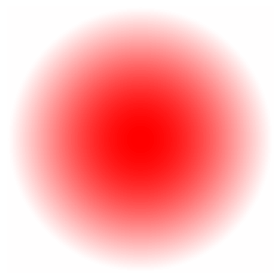

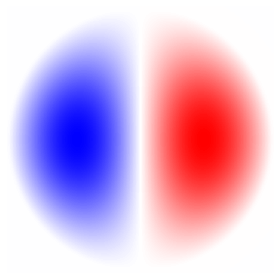

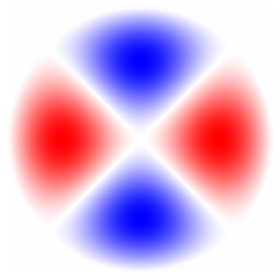

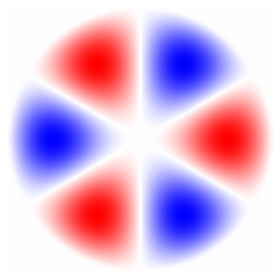

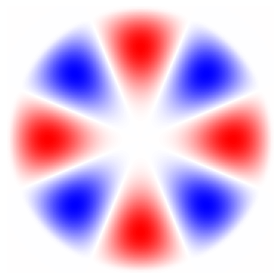

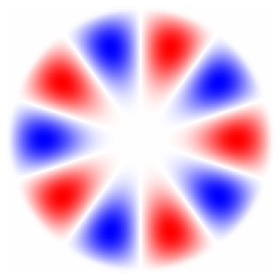

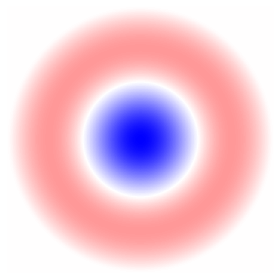

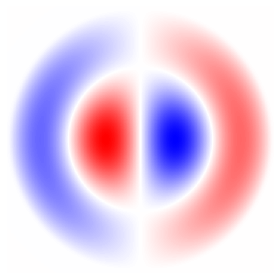

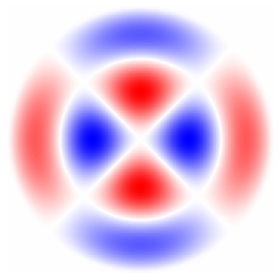

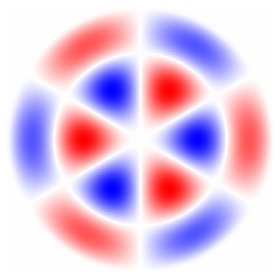

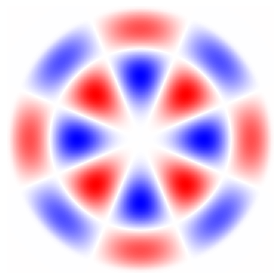

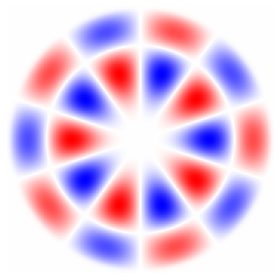

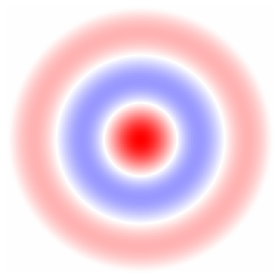

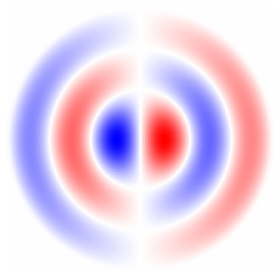

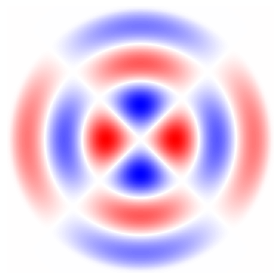

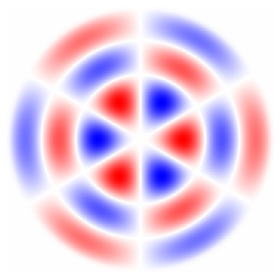

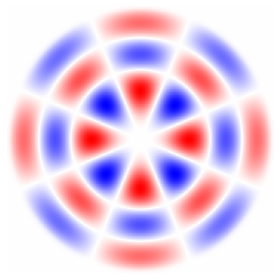

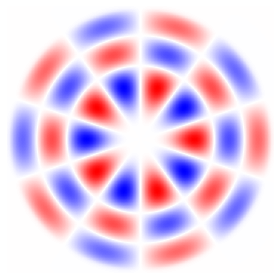

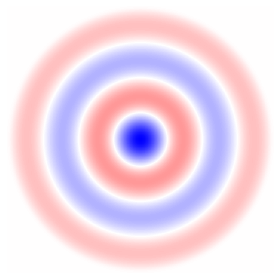

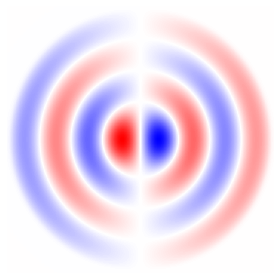

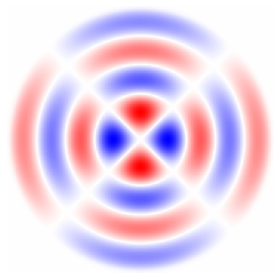

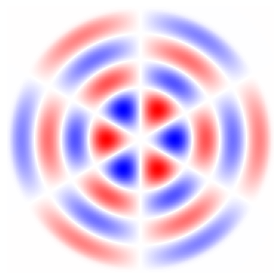

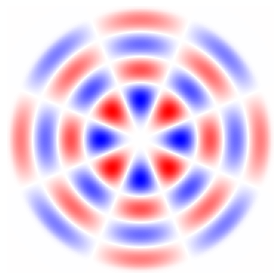

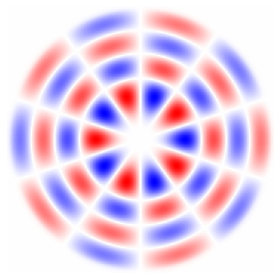

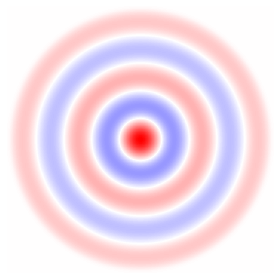

In [114]:
bases = mod_tm.cfc1.bases_in
bases = bases.detach().cpu().numpy()
print(bases.shape)

for i in [0,1,3,5,7,9,117,118,120,122,124,126,224,225,227,229,231,233,321,322,324,326,328,330,410,411,413,415,417,419]:
    fig = plt.figure()
    plt.imshow(np.reshape(np.abs(bases[i])/np.max(np.abs(bases[i])), (180,180))*np.reshape(np.cos(np.arctan2(np.imag(bases[i]),np.real(bases[i]))), (180,180)), clim=[-1,1], cmap='bwr')
    plt.xticks([])
    plt.yticks([])
    plt.gca().set_axis_off()
    plt.subplots_adjust(top = 1, bottom = 0, right = 1, left = 0, 
            hspace = 0, wspace = 0)
    plt.margins(0,0)
    plt.tight_layout()
    plt.show()
#     plt.savefig(f'outputs/figures/bases/basis{i}.pdf', bbox_inches='tight', pad_inches=0)
#     plt.close()
    

(1061, 32400)


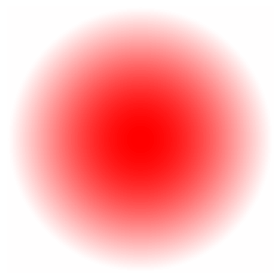

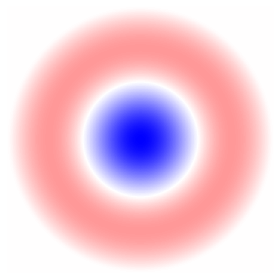

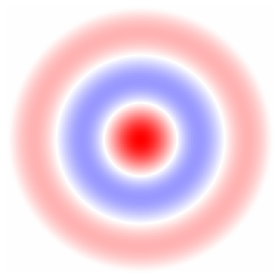

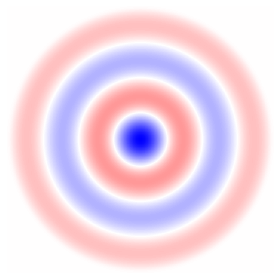

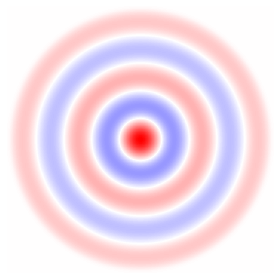

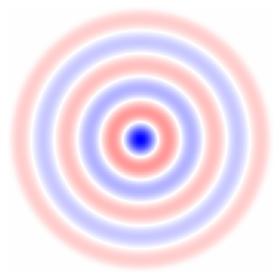

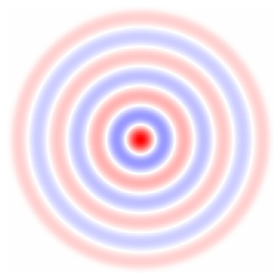

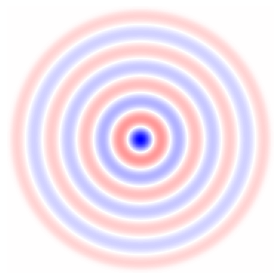

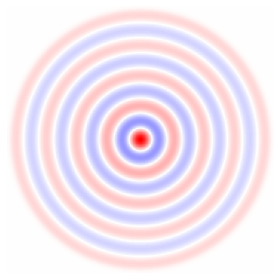

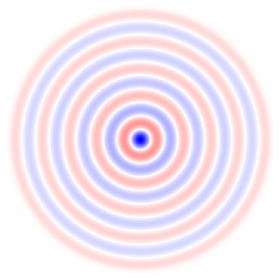

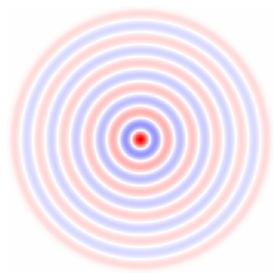

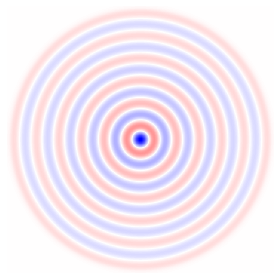

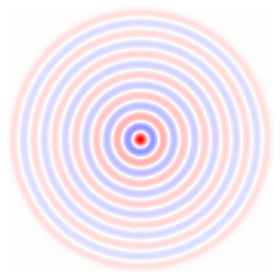

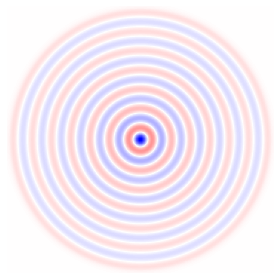

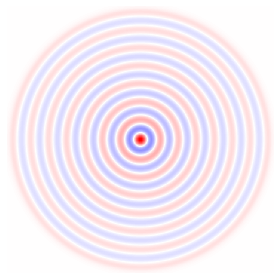

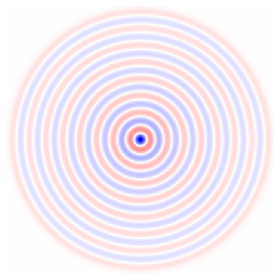

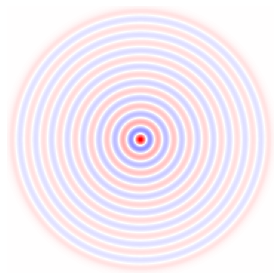

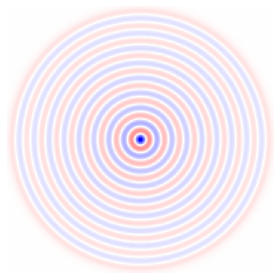

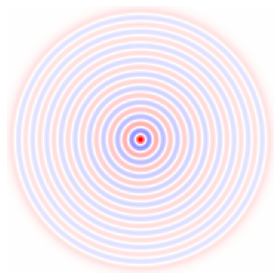

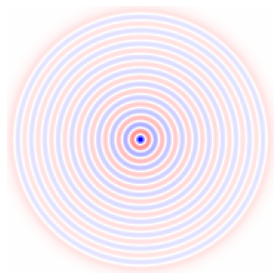

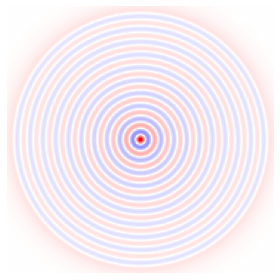

In [62]:
bases = mod_tm.cfc1.bases_in
bases = bases.detach().cpu().numpy()
print(bases.shape)

for i in [0,117,224,321,410,491,566,635,698,755,806,853,894,931,962,989,1012,1031,1046,1055,1060]:
    fig = plt.figure()
    plt.imshow(np.reshape(np.abs(bases[i])/np.max(np.abs(bases[i])), (180,180))*np.reshape(np.cos(np.arctan2(np.imag(bases[i]),np.real(bases[i]))), (180,180)), clim=[-1,1], cmap='bwr')
    plt.xticks([])
    plt.yticks([])
    plt.gca().set_axis_off()
    plt.subplots_adjust(top = 1, bottom = 0, right = 1, left = 0, 
            hspace = 0, wspace = 0)
    plt.margins(0,0)
    plt.tight_layout()
    plt.show()
#     plt.savefig(f'outputs/figures/bases/basis{i}.pdf', bbox_inches='tight', pad_inches=0)
#     plt.close()
    

In [14]:
data_path = f'data/TheoryTM_fmnist_v3/'
file_location = f'train_data.h5'
with h5py.File( data_path + file_location , 'r') as f:
    print("Keys: %s" % f.keys())
    original_imgs_train = np.array(f['original'])#[:6000]
    speckled_imgs_train = np.array(f['speckled'], dtype=np.csingle)#[:6000]
    inverted_imgs_train = np.array(f['inverted'], dtype=np.csingle)#[:6000]
    
print(original_imgs_train.shape)


Keys: <KeysViewHDF5 ['inverted', 'original', 'speckled']>
(12000, 28, 28)


In [15]:
data_path = f'data/TheoryTM_fmnist_v3/'
# data_path = f'data/TheoryTM_mnist/'
file_location = f'test_data.h5'
with h5py.File( data_path + file_location , 'r') as f:
    print("Keys: %s" % f.keys())
    original_imgs_test = np.array(f['original'])
    speckled_imgs_test = np.array(f['speckled'], dtype=np.csingle)
    inverted_imgs_test = np.array(f['inverted'], dtype=np.csingle)

original_imgs_max = np.max(original_imgs_test)
original_imgs_min = np.min(original_imgs_test)
speckled_imgs_max = np.max(np.abs(speckled_imgs_test))
speckled_imgs_min = np.min(np.abs(speckled_imgs_test))
print(f'original_imgs_max : {original_imgs_max}')
print(f'original_imgs_min : {original_imgs_min}')
print(f'speckled_imgs_max : {speckled_imgs_max}')
print(f'speckled_imgs_min : {speckled_imgs_min}')

Keys: <KeysViewHDF5 ['inverted', 'original', 'speckled']>
original_imgs_max : 1.0
original_imgs_min : 0.0
speckled_imgs_max : 0.3980320394039154
speckled_imgs_min : 1.1304997826755425e-07


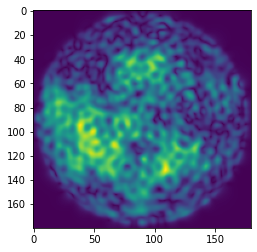

In [16]:
plt.imshow(np.abs(speckled_imgs_test[0]))

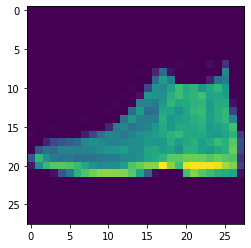

In [17]:
plt.imshow(np.abs(original_imgs_test[0]))

In [8]:
tot_loss = 0
for speckled_img, original_img in zip(speckled_imgs_train,original_imgs_train):
    speckled_img = torch.from_numpy(speckled_img).cuda() 
    original_img = torch.from_numpy(original_img).cuda()

    predicted_img_tm = mod_mlp(speckled_img.view(1,-1))
    predicted_img_tm = torch.abs(predicted_img_tm)
    original_img = original_img.view(1,-1)
    predicted_img_tm = predicted_img_tm.view(1,-1)

    loss = F.mse_loss(predicted_img_tm, original_img)
    tot_loss += loss.item()
print(tot_loss/len(speckled_imgs_train))

tot_loss = 0
for speckled_img, original_img in zip(speckled_imgs_test,original_imgs_test):
    speckled_img = torch.from_numpy(speckled_img).cuda() 
    original_img = torch.from_numpy(original_img).cuda()

    predicted_img_tm = mod_mlp(speckled_img.view(1,-1))
    predicted_img_tm = torch.abs(predicted_img_tm)
    original_img = original_img.view(1,-1)
    predicted_img_tm = predicted_img_tm.view(1,-1)

    loss = F.mse_loss(predicted_img_tm, original_img)
    tot_loss += loss.item()
print(tot_loss/len(speckled_imgs_test))

NameError: name 'mod_mlp' is not defined

In [21]:
tot_loss = 0
for speckled_img, original_img in zip(speckled_imgs_train,original_imgs_train):
    speckled_img = torch.from_numpy(speckled_img).cuda() 
    original_img = torch.from_numpy(original_img).cuda()

    predicted_img_tm = mod_cmlp(speckled_img.view(1,-1))
    predicted_img_tm = torch.abs(predicted_img_tm)
    original_img = original_img.view(1,-1)
    predicted_img_tm = predicted_img_tm.view(1,-1)

    loss = F.mse_loss(predicted_img_tm, original_img)
    tot_loss += loss.item()
print(tot_loss/len(speckled_imgs_train))

tot_loss = 0
for speckled_img, original_img in zip(speckled_imgs_test,original_imgs_test):
    speckled_img = torch.from_numpy(speckled_img).cuda() 
    original_img = torch.from_numpy(original_img).cuda()

    predicted_img_tm = mod_cmlp(speckled_img.view(1,-1))
    predicted_img_tm = torch.abs(predicted_img_tm)
    original_img = original_img.view(1,-1)
    predicted_img_tm = predicted_img_tm.view(1,-1)

    loss = F.mse_loss(predicted_img_tm, original_img)
    tot_loss += loss.item()
print(tot_loss/len(speckled_imgs_test))

0.014876802494972556
0.03634930424951017


In [46]:
add_noise = 0.0
tot_loss = 0
for speckled_img, original_img in zip(speckled_imgs_train,original_imgs_train):
    
    if add_noise != 0.0:
        speckle_max = np.max(np.abs(speckled_img))
        speckled_img[speckled_img > speckle_max*0.9] = speckle_max*0.9
        img_noise = channels_to_complex_np(np.stack([np.random.normal(size=speckled_img.shape).astype(np.float32)*add_noise,np.random.normal(size=speckled_img.shape).astype(np.float32)*add_noise], axis=-1))
        speckled_img = speckled_img + img_noise
                
    speckled_img = torch.from_numpy(speckled_img).cuda()
    original_img = torch.from_numpy(original_img).cuda()

    predicted_img_tm = mod_tm(speckled_img.view(1,-1))
    predicted_img_tm = torch.abs(predicted_img_tm)
    original_img = original_img.view(1,-1)
    predicted_img_tm = predicted_img_tm.view(1,-1)

    loss = F.mse_loss(predicted_img_tm, original_img)
    tot_loss += loss.item()
print(tot_loss/len(speckled_imgs_train))

tot_loss = 0
for speckled_img, original_img in zip(speckled_imgs_test,original_imgs_test):
    
    if add_noise != 0.0:
        speckle_max = np.max(np.abs(speckled_img))
        speckled_img[speckled_img > speckle_max*0.9] = speckle_max*0.9
        img_noise = channels_to_complex_np(np.stack([np.random.normal(size=speckled_img.shape).astype(np.float32)*add_noise,np.random.normal(size=speckled_img.shape).astype(np.float32)*add_noise], axis=-1))
        speckled_img = speckled_img + img_noise
                
    speckled_img = torch.from_numpy(speckled_img).cuda()
    original_img = torch.from_numpy(original_img).cuda()

    predicted_img_tm = mod_tm(speckled_img.view(1,-1))
    predicted_img_tm = torch.abs(predicted_img_tm)
    original_img = original_img.view(1,-1)
    predicted_img_tm = predicted_img_tm.view(1,-1)

    loss = F.mse_loss(predicted_img_tm, original_img)
    tot_loss += loss.item()
print(tot_loss/len(speckled_imgs_test))

0.046335649539832956
0.0453558411449194


In [23]:
tot_loss = 0
for speckled_img, original_img in zip(speckled_imgs_train,original_imgs_train):

    if add_noise != 0.0:
        speckle_max = np.max(np.abs(speckled_img))
        speckled_img[speckled_img > speckle_max*0.9] = speckle_max*0.9
        img_noise = channels_to_complex_np(np.stack([np.random.normal(size=speckled_img.shape).astype(np.float32)*add_noise,np.random.normal(size=speckled_img.shape).astype(np.float32)*add_noise], axis=-1))
        speckled_img = speckled_img + img_noise
                
    speckled_img = torch.from_numpy(speckled_img).cuda()
    original_img = torch.from_numpy(original_img).cuda()

    predicted_img_tm = mod_tm(speckled_img.view(1,-1))
    predicted_img_tm = torch.abs(predicted_img_tm)
    predicted_img_tm = predicted_img_tm.view(-1,1,28,28)
    predicted_img_tm = mod_SR(predicted_img_tm)
    original_img = original_img.view(1,-1)
    predicted_img_tm = predicted_img_tm.view(1,-1)

    loss = F.mse_loss(predicted_img_tm, original_img)
    tot_loss += loss.item()
print(tot_loss/len(speckled_imgs_train))

tot_loss = 0
for speckled_img, original_img in zip(speckled_imgs_test,original_imgs_test):

    if add_noise != 0.0:
        speckle_max = np.max(np.abs(speckled_img))
        speckled_img[speckled_img > speckle_max*0.9] = speckle_max*0.9
        img_noise = channels_to_complex_np(np.stack([np.random.normal(size=speckled_img.shape).astype(np.float32)*add_noise,np.random.normal(size=speckled_img.shape).astype(np.float32)*add_noise], axis=-1))
        speckled_img = speckled_img + img_noise
                
    speckled_img = torch.from_numpy(speckled_img).cuda()
    original_img = torch.from_numpy(original_img).cuda()

    predicted_img_tm = mod_tm(speckled_img.view(1,-1))
    predicted_img_tm = torch.abs(predicted_img_tm)
    predicted_img_tm = predicted_img_tm.view(-1,1,28,28)
    predicted_img_tm = mod_SR(predicted_img_tm)
    original_img = original_img.view(1,-1)
    predicted_img_tm = predicted_img_tm.view(1,-1)

    loss = F.mse_loss(predicted_img_tm, original_img)
    tot_loss += loss.item()
print(tot_loss/len(speckled_imgs_test))

0.0032317071057696013
0.0027846875569666734


In [18]:
# print(f'Trainable params (mil) : {sum(p.numel() for p in mod_mlp.parameters() if p.requires_grad)/1000000}')
# print(f'Params (mil) : {sum(p.numel() for p in mod_mlp.parameters())/1000000}')

# print(f'Trainable params (mil) : {sum(p.numel() for p in mod_cmlp.parameters() if p.requires_grad)/1000000}')
# print(f'Params (mil) : {sum(p.numel() for p in mod_cmlp.parameters())/1000000}')

print(f'Trainable params (mil) : {sum(p.numel() for p in mod_tm.parameters() if p.requires_grad)/1000000}')
print(f'Params (mil) : {sum(p.numel() for p in mod_tm.parameters())/1000000}')

print(f'Trainable params (mil) : {sum(p.numel() for p in mod_SR.parameters() if p.requires_grad)/1000000}')
print(f'Params (mil) : {sum(p.numel() for p in mod_SR.parameters())/1000000}')



Trainable params (mil) : 0.000321
Params (mil) : 10.652385
Trainable params (mil) : 0.222336
Params (mil) : 0.222336


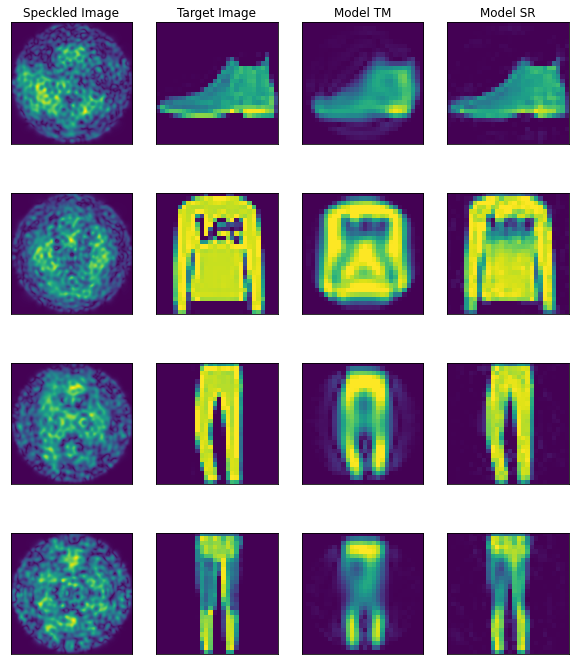

In [19]:
img_nums = [0,1,2,3]
f, ax_arr = plt.subplots(len(img_nums), 5, figsize=(10,12))
for i, img_num in enumerate(img_nums):
    
    speckled_img = speckled_imgs_test[img_num]
#     if add_noise != 0.0:
#         speckle_max = np.max(np.abs(speckled_img))
#         speckled_img[speckled_img > speckle_max*0.9] = speckle_max*0.9
#         img_noise = channels_to_complex_np(np.stack([np.random.normal(size=speckled_img.shape).astype(np.float32)*add_noise,np.random.normal(size=speckled_img.shape).astype(np.float32)*add_noise], axis=-1))
#         speckled_img = speckled_img + img_noise
        
    original_img = torch.from_numpy(original_imgs_test[img_num]).to('cuda')
    speckled_img = torch.from_numpy(speckled_img).to('cuda')
    original_img = original_img.view(1, -1)
    speckled_img = speckled_img.view(1, -1)

    ## Pass image through model
#     predicted_img_mlp = mod_mlp(speckled_img)
#     predicted_img_mlp = torch.abs(predicted_img_mlp)
#     predicted_img_cmlp = mod_cmlp(speckled_img)
#     predicted_img_cmlp = torch.abs(predicted_img_cmlp)
    predicted_img_tm = mod_tm(speckled_img)
    predicted_img_tm = torch.abs(predicted_img_tm)
#     predicted_img_tm /= torch.max(predicted_img_tm)
    predicted_img_sr = predicted_img_tm.view(-1,1,28,28)
    predicted_img_sr = mod_SR(predicted_img_sr)
    
#     predicted_img_mlp = predicted_img_mlp.cpu()
#     predicted_img_cmlp = predicted_img_cmlp.cpu()
    predicted_img_tm = predicted_img_tm.cpu()
    predicted_img_sr = predicted_img_sr.cpu()
    
    original_img = original_img.cpu()
    speckled_img = speckled_img.cpu()
    
#     f, ax_arr = plt.subplots(1, 3, figsize=(20, 13))
    plt.subplot(len(img_nums), 4, 1 + (i*4))
    plt.imshow(torch.abs(speckled_img).view(180,180).detach().cpu().numpy())
    plt.xticks([])
    plt.yticks([])
    if i==0:
        plt.title(f'Speckled Image')
    plt.subplot(len(img_nums), 4, 2 + (i*4))
    plt.imshow(original_img.view(28,28).detach().cpu().numpy(), vmin=0, vmax=1)
    plt.xticks([])
    plt.yticks([])
    if i==0:
        plt.title(f'Target Image')
    plt.subplot(len(img_nums), 4, 3 + (i*4))
    plt.imshow(predicted_img_tm.view(28,28).detach().cpu().numpy(), vmin=0, vmax=1)
    plt.xticks([])
    plt.yticks([])
    if i==0:
        plt.title(f'Model TM')
    plt.subplot(len(img_nums), 4, 4 + (i*4))
    plt.imshow(predicted_img_sr.view(28,28).detach().cpu().numpy(), vmin=0, vmax=1)
    plt.xticks([])
    plt.yticks([])
    if i==0:
        plt.title(f'Model SR')
#     plt.subplot(len(img_nums), 6, 5 + (i*6))
# #     plt.imshow(predicted_img_mlp.view(28,28).detach().cpu().numpy(), vmin=0, vmax=1)
#     axes_off()
#     plt.yticks([])
#     if i==0:
#         plt.title(f'Model MLP')
#     plt.subplot(len(img_nums), 6, 6 + (i*6))
# #     plt.imshow(predicted_img_cmlp.view(28,28).detach().cpu().numpy(), vmin=0, vmax=1)
#     axes_off()
#     plt.yticks([])
#     if i==0:
#         plt.title(f'Model CMLP')

    
# plt.tight_layout()
# plt.subplots_adjust(wspace=0.01,hspace=0.01)
# plt.savefig(f'outputs/compare_results_original_img.pdf')
plt.show()

/tmp/ipykernel_10/1774580373.py:59: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure()


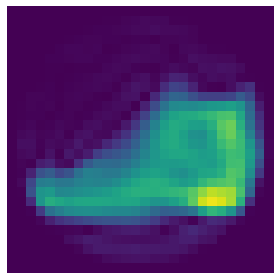

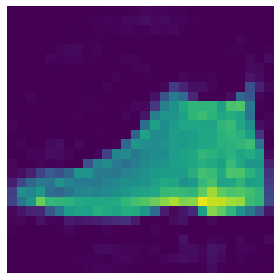

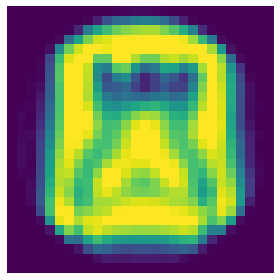

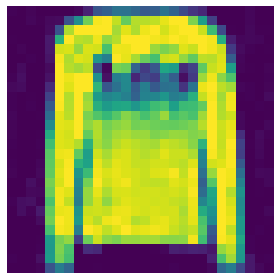

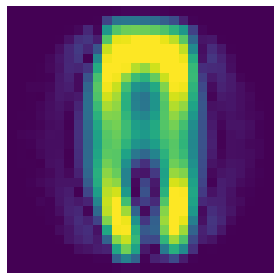

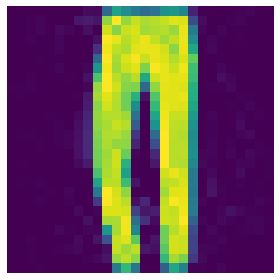

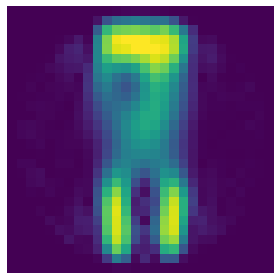

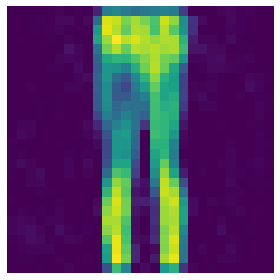

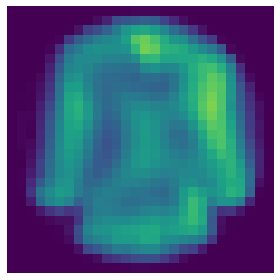

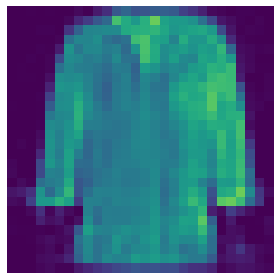

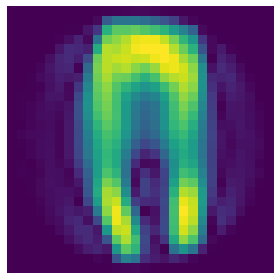

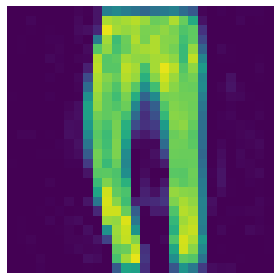

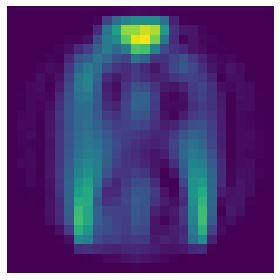

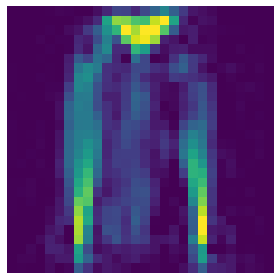

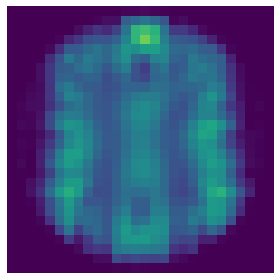

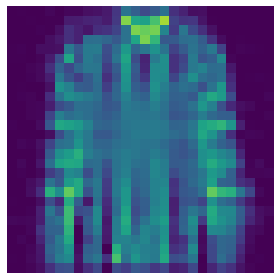

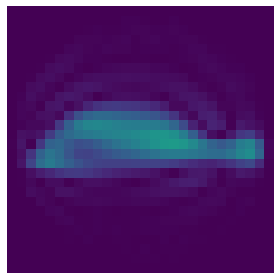

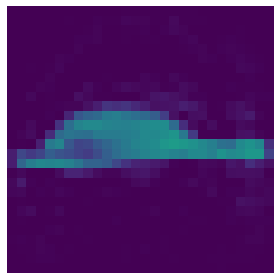

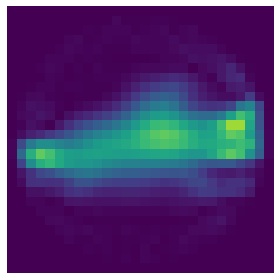

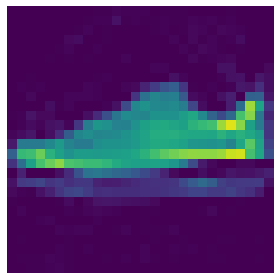

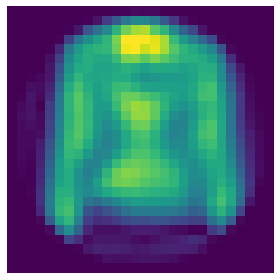

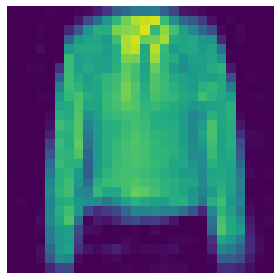

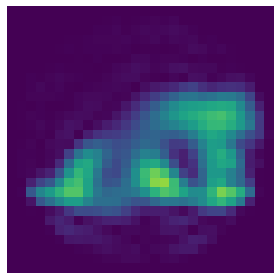

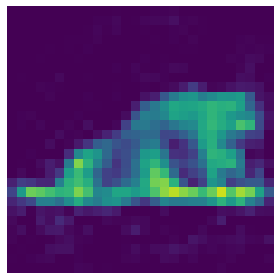

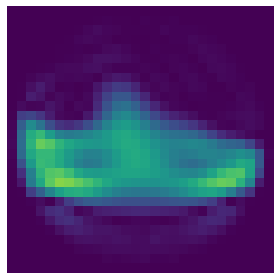

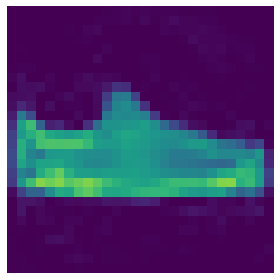

In [20]:
img_nums = [0,1,2,3,4,5,6,7,8,9,10,11,12]
for i, img_num in enumerate(img_nums):
    speckled_img = speckled_imgs_test[img_num]
#     if add_noise != 0.0:
#         speckle_max = np.max(np.abs(speckled_img))
#         speckled_img[speckled_img > speckle_max*0.9] = speckle_max*0.9
#         img_noise = channels_to_complex_np(np.stack([np.random.normal(size=speckled_img.shape).astype(np.float32)*add_noise,np.random.normal(size=speckled_img.shape).astype(np.float32)*add_noise], axis=-1))
#         speckled_img = speckled_img + img_noise
        
    original_img = torch.from_numpy(original_imgs_test[img_num]).to('cuda')
    speckled_img = torch.from_numpy(speckled_img).to('cuda')
#     speckled_img = speckled_img / torch.max(torch.abs(speckled_img))
    original_img = original_img.view(1, -1)
    speckled_img = speckled_img.view(1, -1)

    ## Pass image through model
#     predicted_img_mlp = mod_mlp(speckled_img)
#     predicted_img_mlp = torch.abs(predicted_img_mlp)
#     predicted_img_cmlp = mod_cmlp(speckled_img)
#     predicted_img_cmlp = torch.abs(predicted_img_cmlp)
    predicted_img_tm = mod_tm(speckled_img)
    predicted_img_tm = torch.abs(predicted_img_tm)
    predicted_img_sr = predicted_img_tm.view(-1,1,28,28)
    predicted_img_sr = mod_SR(predicted_img_sr)
    
#     predicted_img_mlp = predicted_img_mlp.cpu()
#     predicted_img_cmlp = predicted_img_cmlp.cpu()
    predicted_img_tm = predicted_img_tm.cpu()
    predicted_img_sr = predicted_img_sr.cpu()
    
    original_img = original_img.cpu()
    speckled_img = speckled_img.cpu()
    
#     f, ax_arr = plt.subplots(1, 3, figsize=(20, 13))
#     fig = plt.figure()
#     im = torch.abs(speckled_img).view(180,180).detach().cpu().numpy()
#     plt.imshow(im)
#     plt.xticks([])
#     plt.yticks([])
#     plt.gca().set_axis_off()
#     plt.subplots_adjust(top = 1, bottom = 0, right = 1, left = 0, 
#             hspace = 0, wspace = 0)
#     plt.margins(0,0)
#     plt.tight_layout()
#     plt.savefig(f'outputs/figures/fmnist_mnist_test/speckled_{i}.pdf', bbox_inches='tight', pad_inches=0)
    
#     fig = plt.figure()
#     im = original_img.view(28,28).detach().cpu().numpy()
#     plt.imshow(im, vmin=0, vmax=1)
#     plt.xticks([])
#     plt.yticks([])
#     plt.gca().set_axis_off()
#     plt.subplots_adjust(top = 1, bottom = 0, right = 1, left = 0, 
#             hspace = 0, wspace = 0)
#     plt.margins(0,0)
#     plt.tight_layout()
#     plt.savefig(f'outputs/figures/fmnist_mnist_test/original_{i}.pdf', bbox_inches='tight', pad_inches=0)
    
    fig = plt.figure()
    im = predicted_img_tm.view(28,28).detach().cpu().numpy()
    plt.imshow(im, vmin=0, vmax=1)
    plt.xticks([])
    plt.yticks([])
    plt.gca().set_axis_off()
    plt.subplots_adjust(top = 1, bottom = 0, right = 1, left = 0, 
            hspace = 0, wspace = 0)
    plt.margins(0,0)
    plt.tight_layout()
    plt.savefig(f'outputs/figures/fmnist_red_bases/TM_bases_{i}_322.pdf', bbox_inches='tight', pad_inches=0)
    
    fig = plt.figure()
    im = predicted_img_sr.view(28,28).detach().cpu().numpy()
    plt.imshow(im, vmin=0, vmax=1)
    plt.xticks([])
    plt.yticks([])
    plt.gca().set_axis_off()
    plt.subplots_adjust(top = 1, bottom = 0, right = 1, left = 0, 
            hspace = 0, wspace = 0)
    plt.margins(0,0)
    plt.tight_layout()
    plt.savefig(f'outputs/figures/fmnist_red_bases/TM_bases_SR_{i}_322.pdf', bbox_inches='tight', pad_inches=0)
    
#     fig = plt.figure()
#     im = predicted_img_mlp.view(28,28).detach().cpu().numpy()
#     plt.imshow(im, vmin=0, vmax=1)
#     axes_off()
#     plt.yticks([])
#     plt.gca().set_axis_off()
#     plt.subplots_adjust(top = 1, bottom = 0, right = 1, left = 0, 
#             hspace = 0, wspace = 0)
#     plt.margins(0,0)
#     plt.tight_layout()
#     plt.savefig(f'outputs/figures/fmnist_mnist_test/MLP_{i}.pdf', bbox_inches='tight', pad_inches=0)
    
#     fig = plt.figure()
#     im = predicted_img_cmlp.view(28,28).detach().cpu().numpy()
#     plt.imshow(im, vmin=0, vmax=1)
#     axes_off()
#     plt.yticks([])
#     plt.gca().set_axis_off()
#     plt.subplots_adjust(top = 1, bottom = 0, right = 1, left = 0, 
#             hspace = 0, wspace = 0)
#     plt.margins(0,0)
#     plt.tight_layout()
#     plt.savefig(f'outputs/figures/fmnist_mnist_test/CMLP_{i}.pdf', bbox_inches='tight', pad_inches=0)


## How about test a model trained on f-minst on mnist

In [16]:
data_path = f'data/TheoryTM_mnist/'
file_location = f'test_data.h5'
with h5py.File( data_path + file_location , 'r') as f:
    print("Keys: %s" % f.keys())
    original_imgs_test = np.array(f['original'])
    speckled_imgs_test = np.array(f['speckled'], dtype=np.csingle)
    inverted_imgs_test = np.array(f['inverted'], dtype=np.csingle)

original_imgs_max = np.max(original_imgs_test)
original_imgs_min = np.min(original_imgs_test)
speckled_imgs_max = np.max(np.abs(speckled_imgs_test))
speckled_imgs_min = np.min(np.abs(speckled_imgs_test))
print(f'original_imgs_max : {original_imgs_max}')
print(f'original_imgs_min : {original_imgs_min}')
print(f'speckled_imgs_max : {speckled_imgs_max}')
print(f'speckled_imgs_min : {speckled_imgs_min}')

Keys: <KeysViewHDF5 ['inverted', 'original', 'speckled']>
original_imgs_max : 1.0
original_imgs_min : 0.0
speckled_imgs_max : 0.34498313069343567
speckled_imgs_min : 8.158298925309282e-08


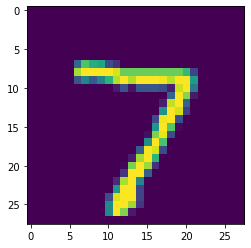

In [17]:
plt.imshow(np.abs(original_imgs_test[0]))

In [18]:
tot_loss = 0
for speckled_img, original_img in zip(speckled_imgs_test,original_imgs_test):
#     speckled_img = speckled_img / np.max(np.abs(speckled_img))
    speckled_img = torch.from_numpy(speckled_img).cuda() 
    original_img = torch.from_numpy(original_img).cuda()

    predicted_img_tm = mod_mlp(speckled_img.view(1,-1))
    predicted_img_tm = torch.abs(predicted_img_tm)
    original_img = original_img.view(1,-1)
    predicted_img_tm = predicted_img_tm.view(1,-1)

    loss = F.mse_loss(predicted_img_tm, original_img)
    tot_loss += loss.item()
print(tot_loss/len(speckled_imgs_test))

0.06411644589093825


In [19]:
tot_loss = 0
for speckled_img, original_img in zip(speckled_imgs_test,original_imgs_test):
#     speckled_img = speckled_img / np.max(np.abs(speckled_img))
    speckled_img = torch.from_numpy(speckled_img).cuda() 
    original_img = torch.from_numpy(original_img).cuda()

    predicted_img_tm = mod_cmlp(speckled_img.view(1,-1))
    predicted_img_tm = torch.abs(predicted_img_tm)
    original_img = original_img.view(1,-1)
    predicted_img_tm = predicted_img_tm.view(1,-1)

    loss = F.mse_loss(predicted_img_tm, original_img)
    tot_loss += loss.item()
print(tot_loss/len(speckled_imgs_test))

0.036350203341183565


In [20]:
tot_loss = 0
for speckled_img, original_img in zip(speckled_imgs_test,original_imgs_test):
#     speckled_img = speckled_img / np.max(np.abs(speckled_img))
    speckled_img = torch.from_numpy(speckled_img).cuda()
    original_img = torch.from_numpy(original_img).cuda()

    predicted_img_tm = mod_tm(speckled_img.view(1,-1))
    predicted_img_tm = torch.abs(predicted_img_tm)
#     predicted_img_tm /= torch.max(predicted_img_tm)
    original_img = original_img.view(1,-1)
    predicted_img_tm = predicted_img_tm.view(1,-1)

    loss = F.mse_loss(predicted_img_tm, original_img)
    tot_loss += loss.item()
print(tot_loss/len(speckled_imgs_test))

0.002645830870955251


In [21]:
tot_loss = 0
for speckled_img, original_img in zip(speckled_imgs_test,original_imgs_test):
#     speckled_img = speckled_img / np.max(np.abs(speckled_img))
    speckled_img = torch.from_numpy(speckled_img).cuda()
    original_img = torch.from_numpy(original_img).cuda()

    predicted_img_tm = mod_tm(speckled_img.view(1,-1))
    predicted_img_tm = torch.abs(predicted_img_tm)
    predicted_img_tm = predicted_img_tm.view(-1,1,28,28)
    predicted_img_tm = mod_SR(predicted_img_tm)
    original_img = original_img.view(1,-1)
    predicted_img_tm = predicted_img_tm.view(1,-1)

    loss = F.mse_loss(predicted_img_tm, original_img)
    tot_loss += loss.item()
print(tot_loss/len(speckled_imgs_test))

0.0027842975102054576


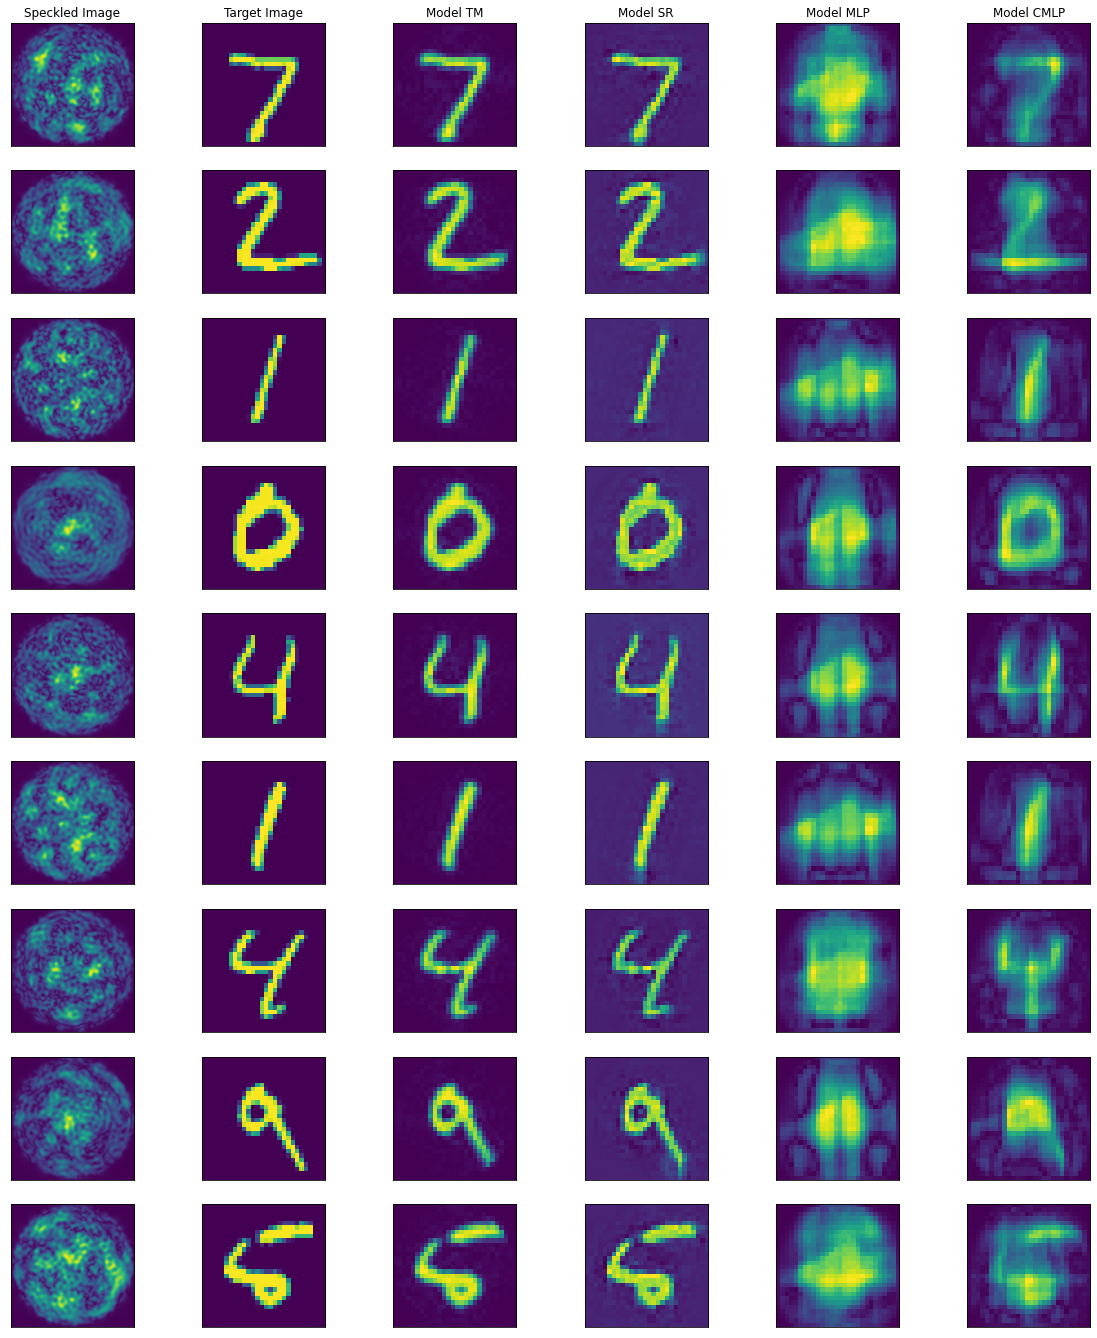

In [22]:
img_nums = [0,1,2,3,4,5,6,7,8]
f, ax_arr = plt.subplots(len(img_nums), 5, figsize=(20,24))
for i, img_num in enumerate(img_nums):
    original_img = torch.from_numpy(original_imgs_test[img_num]).to('cuda')
    speckled_img = torch.from_numpy(speckled_imgs_test[img_num]).to('cuda')
#     print(torch.max(torch.abs(speckled_img)))
#     speckled_img = speckled_img / torch.max(torch.abs(speckled_img))
    original_img = original_img.view(1, -1)
    speckled_img = speckled_img.view(1, -1)

    ## Pass image through model
    predicted_img_mlp = mod_mlp(speckled_img)
    predicted_img_mlp = torch.abs(predicted_img_mlp)
    predicted_img_cmlp = mod_cmlp(speckled_img)
    predicted_img_cmlp = torch.abs(predicted_img_cmlp)
    predicted_img_tm = mod_tm(speckled_img)
    predicted_img_tm = torch.abs(predicted_img_tm)
#     predicted_img_tm /= torch.max(predicted_img_tm)
    predicted_img_sr = predicted_img_tm.view(-1,1,28,28)
    predicted_img_sr = mod_SR(predicted_img_sr)
    
    predicted_img_mlp = predicted_img_mlp.cpu()
    predicted_img_cmlp = predicted_img_cmlp.cpu()
    predicted_img_tm = predicted_img_tm.cpu()
    predicted_img_sr = predicted_img_sr.cpu()
    
    original_img = original_img.cpu()
    speckled_img = speckled_img.cpu()
    
#     f, ax_arr = plt.subplots(1, 3, figsize=(20, 13))
    plt.subplot(len(img_nums), 6, 1 + (i*6))
    plt.imshow(torch.abs(speckled_img).view(180,180).detach().cpu().numpy())
    plt.xticks([])
    plt.yticks([])
    if i==0:
        plt.title(f'Speckled Image')
    plt.subplot(len(img_nums), 6, 2 + (i*6))
#     print(torch.max(original_img))
    plt.imshow(original_img.view(28,28).detach().cpu().numpy())
    plt.xticks([])
    plt.yticks([])
    if i==0:
        plt.title(f'Target Image')
    plt.subplot(len(img_nums), 6, 3 + (i*6))
#     print(torch.max(predicted_img_tm))
    plt.imshow(predicted_img_tm.view(28,28).detach().cpu().numpy())
    plt.xticks([])
    plt.yticks([])
    if i==0:
        plt.title(f'Model TM')
    plt.subplot(len(img_nums), 6, 4 + (i*6))
    plt.imshow(predicted_img_sr.view(28,28).detach().cpu().numpy())
    plt.xticks([])
    plt.yticks([])
    if i==0:
        plt.title(f'Model SR')
    plt.subplot(len(img_nums), 6, 5 + (i*6))
    plt.imshow(predicted_img_mlp.view(28,28).detach().cpu().numpy())
    axes_off()
    plt.yticks([])
    if i==0:
        plt.title(f'Model MLP')
    plt.subplot(len(img_nums), 6, 6 + (i*6))
    plt.imshow(predicted_img_cmlp.view(28,28).detach().cpu().numpy())
    axes_off()
    plt.yticks([])
    if i==0:
        plt.title(f'Model CMLP')

    
# plt.tight_layout()
# plt.subplots_adjust(wspace=0.01,hspace=0.01)
# plt.savefig(f'outputs/compare_results_original_img.pdf')
plt.show()

/tmp/ipykernel_22016/745939855.py:50: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure()


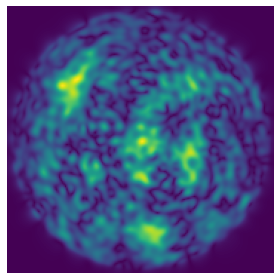

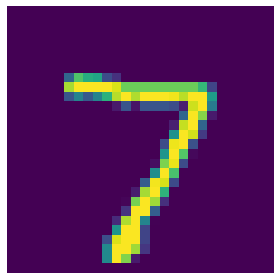

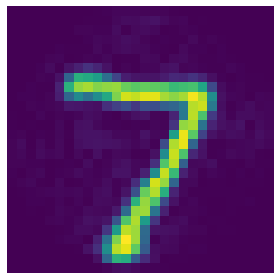

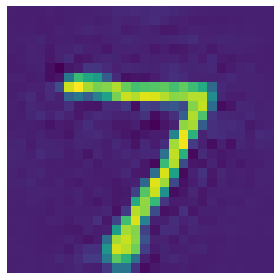

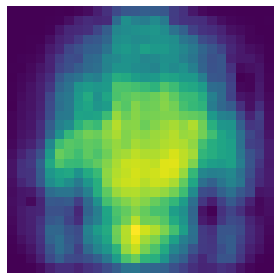

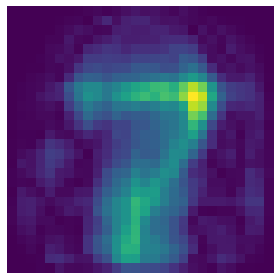

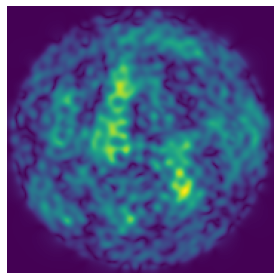

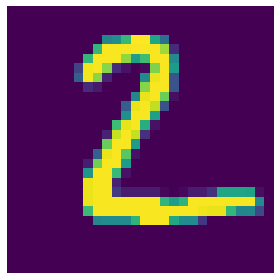

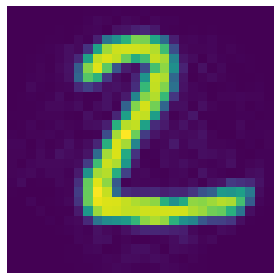

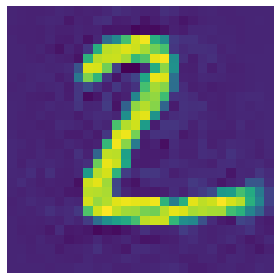

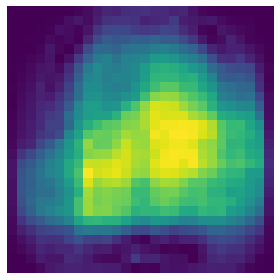

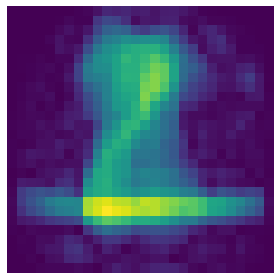

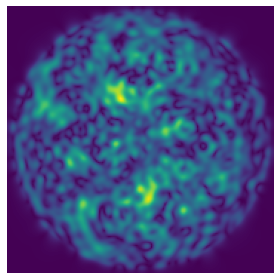

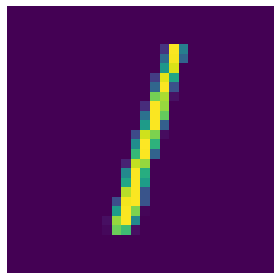

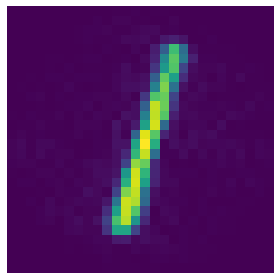

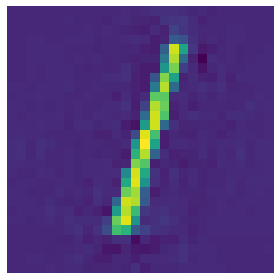

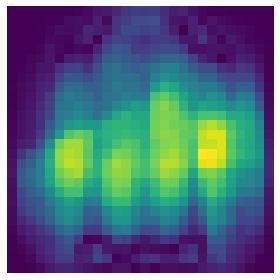

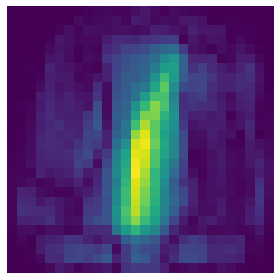

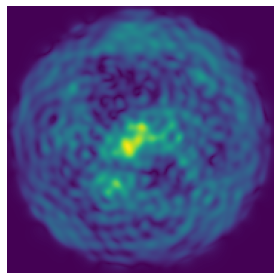

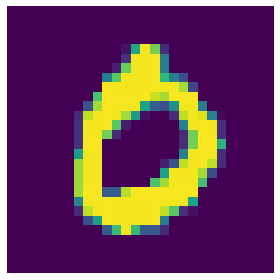

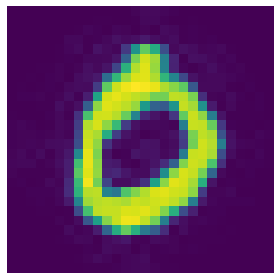

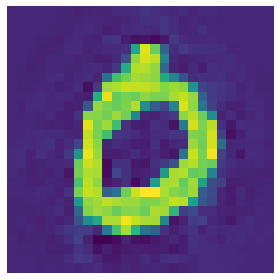

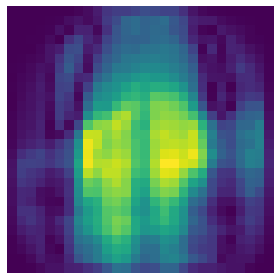

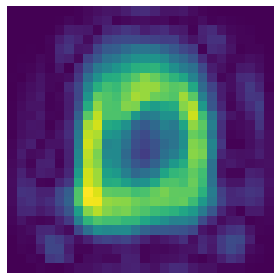

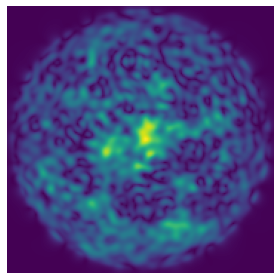

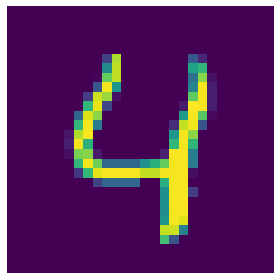

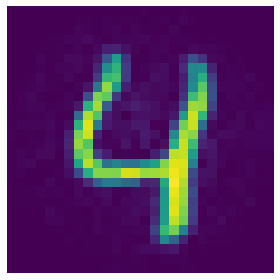

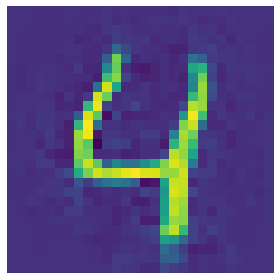

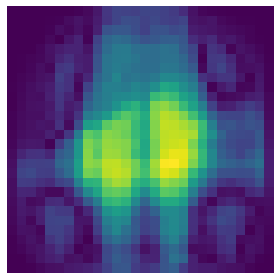

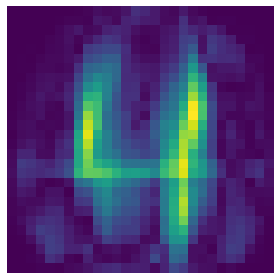

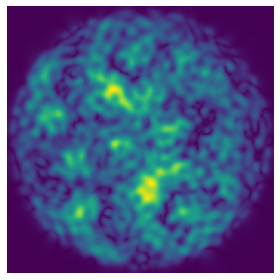

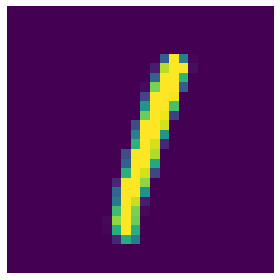

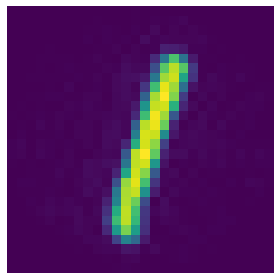

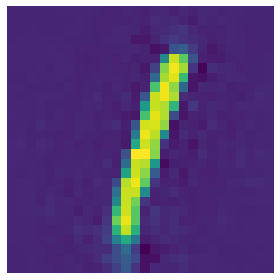

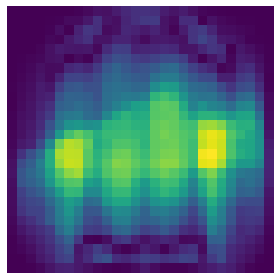

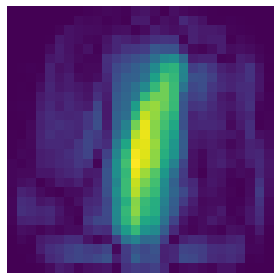

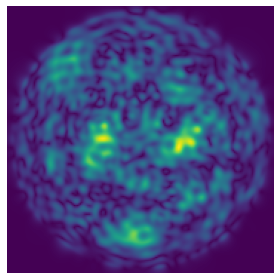

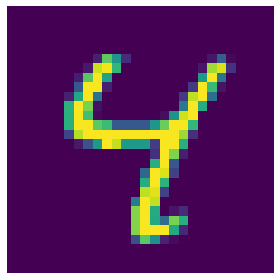

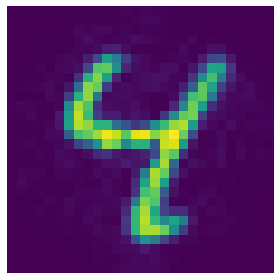

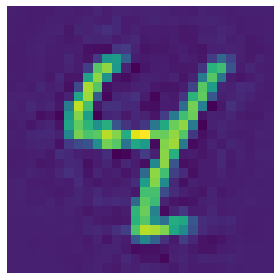

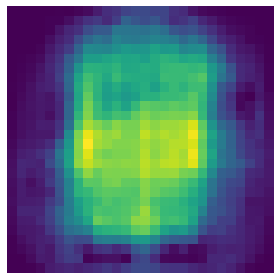

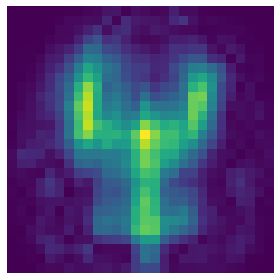

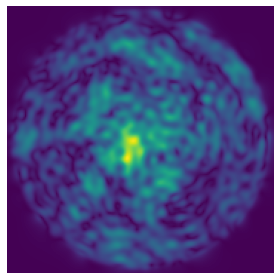

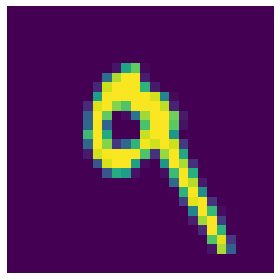

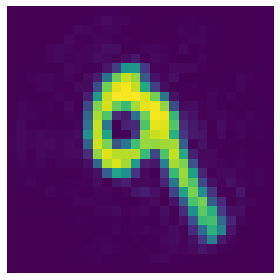

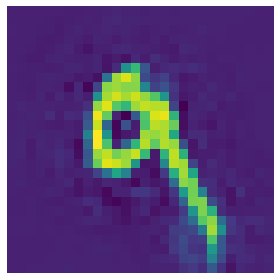

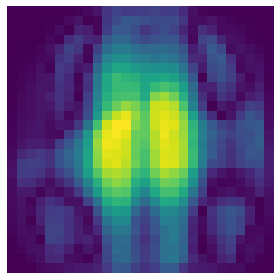

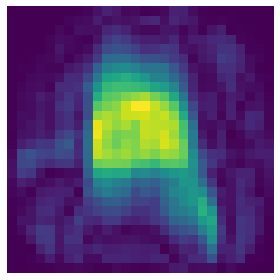

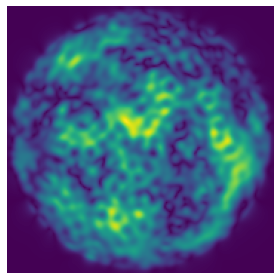

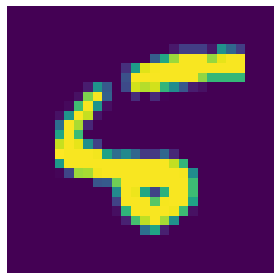

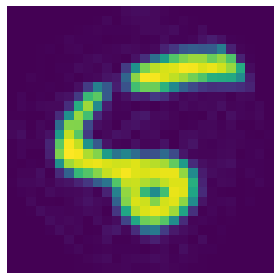

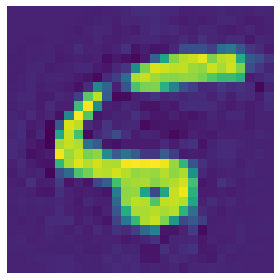

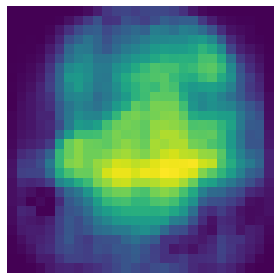

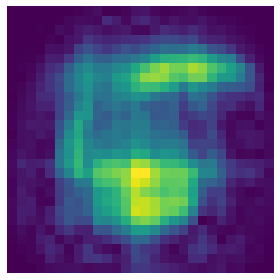

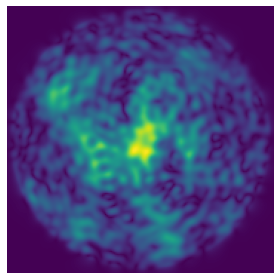

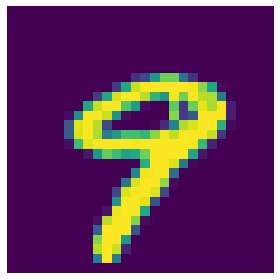

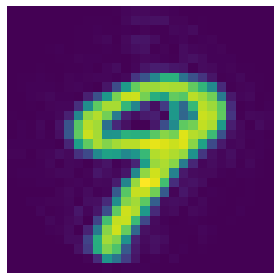

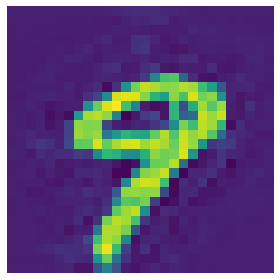

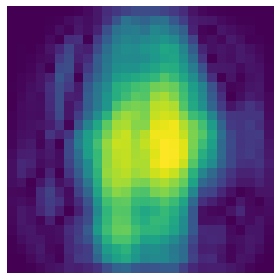

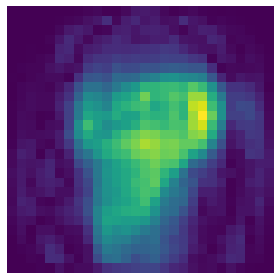

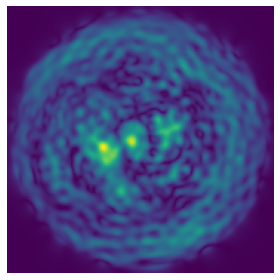

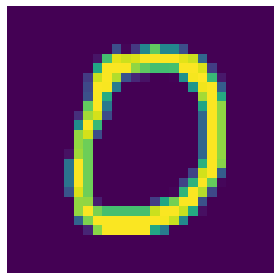

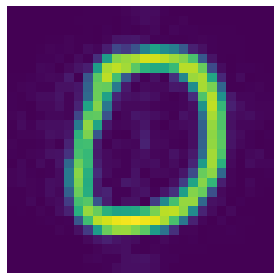

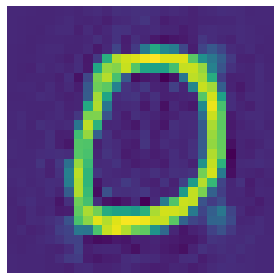

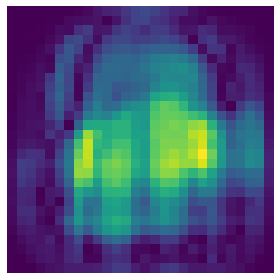

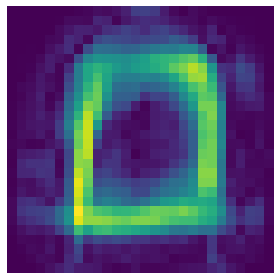

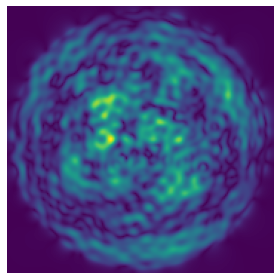

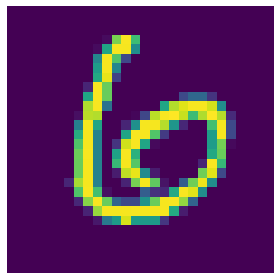

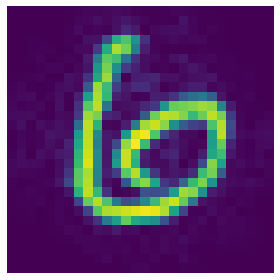

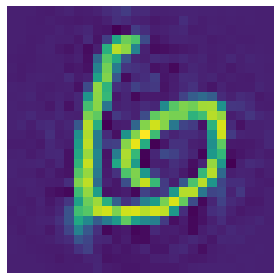

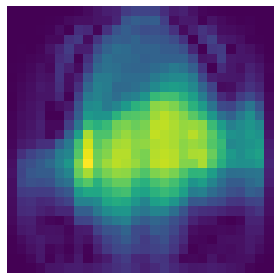

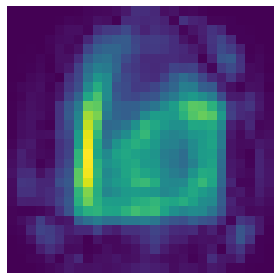

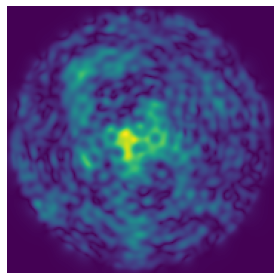

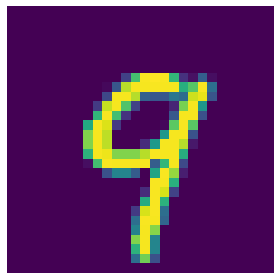

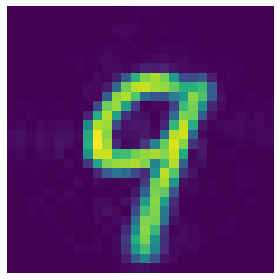

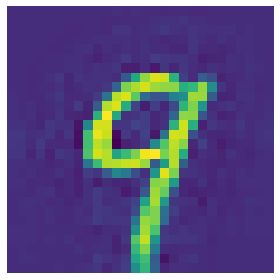

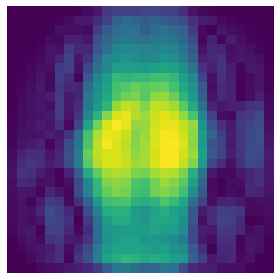

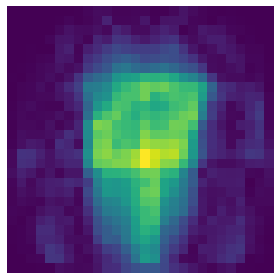

In [23]:
img_nums = [0,1,2,3,4,5,6,7,8,9,10,11,12]
for i, img_num in enumerate(img_nums):
    original_img = torch.from_numpy(original_imgs_test[img_num]).to('cuda')
    speckled_img = torch.from_numpy(speckled_imgs_test[img_num]).to('cuda')
    speckled_img = speckled_img / torch.max(torch.abs(speckled_img))
    original_img = original_img.view(1, -1)
    speckled_img = speckled_img.view(1, -1)

    ## Pass image through model
    predicted_img_mlp = mod_mlp(speckled_img)
    predicted_img_mlp = torch.abs(predicted_img_mlp)
    predicted_img_cmlp = mod_cmlp(speckled_img)
    predicted_img_cmlp = torch.abs(predicted_img_cmlp)
    predicted_img_tm = mod_tm(speckled_img)
    predicted_img_tm = torch.abs(predicted_img_tm)
    predicted_img_sr = predicted_img_tm.view(-1,1,28,28)
    predicted_img_sr = mod_SR(predicted_img_sr)
    
    predicted_img_mlp = predicted_img_mlp.cpu()
    predicted_img_cmlp = predicted_img_cmlp.cpu()
    predicted_img_tm = predicted_img_tm.cpu()
    predicted_img_sr = predicted_img_sr.cpu()
    
    original_img = original_img.cpu()
    speckled_img = speckled_img.cpu()
    
#     f, ax_arr = plt.subplots(1, 3, figsize=(20, 13))
    fig = plt.figure()
    plt.imshow(torch.abs(speckled_img).view(180,180).detach().cpu().numpy())
    plt.xticks([])
    plt.yticks([])
    plt.gca().set_axis_off()
    plt.subplots_adjust(top = 1, bottom = 0, right = 1, left = 0, 
            hspace = 0, wspace = 0)
    plt.margins(0,0)
    plt.tight_layout()
    plt.savefig(f'outputs/figures/fmnist_mnist_test/speckled_{i}.pdf', bbox_inches='tight', pad_inches=0)
    
    fig = plt.figure()
    plt.imshow(original_img.view(28,28).detach().cpu().numpy())
    plt.xticks([])
    plt.yticks([])
    plt.gca().set_axis_off()
    plt.subplots_adjust(top = 1, bottom = 0, right = 1, left = 0, 
            hspace = 0, wspace = 0)
    plt.margins(0,0)
    plt.tight_layout()
    plt.savefig(f'outputs/figures/fmnist_mnist_test/original_{i}.pdf', bbox_inches='tight', pad_inches=0)
    
    fig = plt.figure()
    plt.imshow(predicted_img_tm.view(28,28).detach().cpu().numpy())
    plt.xticks([])
    plt.yticks([])
    plt.gca().set_axis_off()
    plt.subplots_adjust(top = 1, bottom = 0, right = 1, left = 0, 
            hspace = 0, wspace = 0)
    plt.margins(0,0)
    plt.tight_layout()
    plt.savefig(f'outputs/figures/fmnist_mnist_test/TM_bases_{i}.pdf', bbox_inches='tight', pad_inches=0)
    
    fig = plt.figure()
    plt.imshow(predicted_img_sr.view(28,28).detach().cpu().numpy())
    plt.xticks([])
    plt.yticks([])
    plt.gca().set_axis_off()
    plt.subplots_adjust(top = 1, bottom = 0, right = 1, left = 0, 
            hspace = 0, wspace = 0)
    plt.margins(0,0)
    plt.tight_layout()
    plt.savefig(f'outputs/figures/fmnist_mnist_test/TM_bases_SR_{i}.pdf', bbox_inches='tight', pad_inches=0)
    
    fig = plt.figure()
    plt.imshow(predicted_img_mlp.view(28,28).detach().cpu().numpy())
    axes_off()
    plt.yticks([])
    plt.gca().set_axis_off()
    plt.subplots_adjust(top = 1, bottom = 0, right = 1, left = 0, 
            hspace = 0, wspace = 0)
    plt.margins(0,0)
    plt.tight_layout()
    plt.savefig(f'outputs/figures/fmnist_mnist_test/MLP_{i}.pdf', bbox_inches='tight', pad_inches=0)
    
    fig = plt.figure()
    plt.imshow(predicted_img_cmlp.view(28,28).detach().cpu().numpy())
    axes_off()
    plt.yticks([])
    plt.gca().set_axis_off()
    plt.subplots_adjust(top = 1, bottom = 0, right = 1, left = 0, 
            hspace = 0, wspace = 0)
    plt.margins(0,0)
    plt.tight_layout()
    plt.savefig(f'outputs/figures/fmnist_mnist_test/CMLP_{i}.pdf', bbox_inches='tight', pad_inches=0)
